# Digit Classifier w/ MNIST

This is my first time working with image classification so I am following along with Yassine Ghouzam's excellent CNN introduction kernel (https://www.kaggle.com/yassineghouzam). I made some modifications here and there mostly as clarification for myself and for future reference.

### Table of Contents
1. Loading in data
2. Data Preparation
3. Modeling
4. Evaluation
5. Output

## 1. Loading in data

### 1.1 Load data

***
As usual the first thing we need to do is load in the various packages we are going to be using.
***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

***
Now that we have the packages we are going to use, we need to load in the data set. Our data has already been added to this notebook under the `../input/` folder so we don't need to go find it. 
***

In [3]:
# Pathing
train = pd.read_csv('datasets/MNIST/train.csv')
test = pd.read_csv('datasets/MNIST/test.csv')

### 1.2 Preliminary Exploration

***
Once we have loaded our data we want to do some preliminary exploration to get a sense of what we are dealing with. A good place to start is with `describe()` and `columns` as they tells us a lot about the data.
***

In [4]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

***
The data is organized as one row is a digit with 784 values per digit is one long array and one label value. This works out to be a 28x28 image which we will deal with in a bit. For now lets see how many of each digit there is.
***

In [6]:
y_train = train['label']
x_train = train.copy(deep = True)
x_train = x_train.drop('label',axis=1)

In [7]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

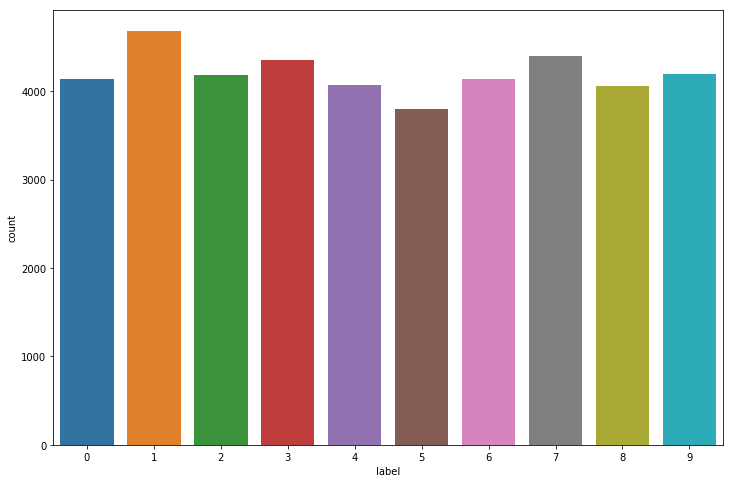

In [8]:
plt.figure(figsize=(1.5*8,8))
sns.countplot(y_train);

***
In our training set there seems to be roughly an even distribution among all numbers. This means we don't have to take into account whether the training set and test set have different distributions and we won't overtrain because of it.
***

### 2.1 Checking for missing values

***
The next thing we need to do is check to see if theere are any missing values as that will mess up the training process. Luckily the values for each pixel are just one or zero so if there are any null values we won't have to do much work to correct them.
***

In [9]:
print(x_train.isnull().any().sum(),y_train.isnull().any().sum())

0 0


***
There are no missing values so we can proceed to the next step.
***

### 2.2 Normalize and Reshape

***
For the next step we need to reshape our arrays from 1D to 2D and also normalize the values (greyscale going from 0-255) to have our model converge faster between 0-1. To do this we just divide all the values by the maximum, 255.
***

In [10]:
x_train = x_train / 255.0
test = test / 255.0

***
Our arrays are 784 elements long that translates into a 2D array of 28x28. To reshape them we use `reshape()` passing the arguments `(-1,28,28,1)` where the -1 tells `reshape()` to use all the columns for a row, the 28s are for the height and width, and the 1 is for the channel (think RGB) which is for greyscale/brightness.
***

In [11]:
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### 2.3 One-Hot Encoding

***
The next step we need to do is convert our labels from 1-10 to 10 separate lables where a 1 identifies that it is a specific number and a 0 that it is not; this is called One-Hot encoding. We do this because 8 is not 8 times better than 1 so we are changing the labels from values into strings or names.
***

In [12]:
y_train = to_categorical(y_train,num_classes=10)

### 2.4 Creating training and test sets

***
The last thing we need to do before beginning the modeling process is to split up our training set further into another training and validation set (not a test set, that is the final step!) using `scikit-learn`'s `train_test_split()`. To prevent overfitting a general guideline for how much of your training set should be set aside for the validation set is about 20%.
***

In [13]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, 
                                                      test_size = 0.2,random_state=42)

***
Before we move on to modeling let's take a look at the data now that we have reshaped it and normalized it.
***

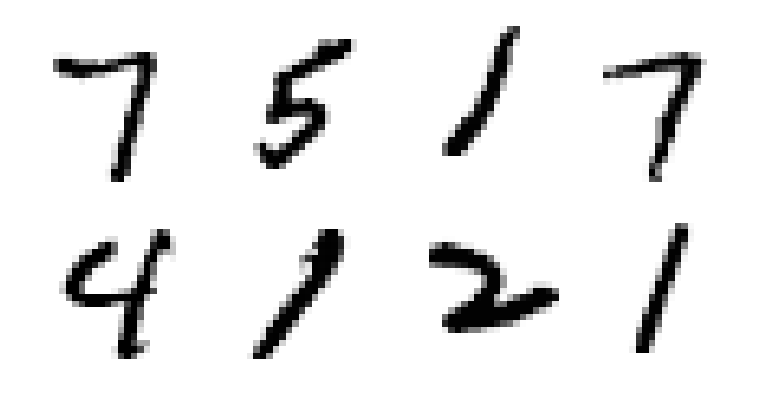

In [14]:
# Gridspec_kw is the dict that you can pass the keys wspace,hspace = 0 to so that 
# it removes the whitespace between subplots. The aspect ratio is still set to 
# 'equal' however, so depending on the dimensions of the data you are plotting 
# you may need to change the figsize to remove horizontal whitespace.
fig, ax = plt.subplots(2, 4,figsize=(13,7),gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(2):
    for j in range(4):
        ax[i,j].imshow(X_train[random.randint(0,100)][:,:,0],cmap='Greys') #row=0, col=0
        ax[i,j].axis('off')

plt.show()

## 3. Modeling

### 3.1 Initializing the model

***
Now that are data is ready to go we can begin building our model. The model we will be using for this project is a Convolutional Neural Network (CNN) which are neural nets designed to mimick how the neural cortex works in animals. CNNs are commonly applied to visual learning tasks and are less prone to overfitting problems than their more complex cousin the Perceptron.

The CNN we are going to be using is a little complex upfront so it would be good to define some of the tools we will use.
* `Sequential()` is a Keras function that sets up the pipeline for the model by sequentially adding layers as we go.
* `Conv2D()` is a 2D filter layer with inputs being how many filters you want and the size of each filter.
* `MaxPool2D()` is a downsampling filter that looks at the neighboring two pixels and picks the highest value. The argument we pass it (2,2) tells it to reduce both the x and y dimensions by half. We use the *relu* rectifier activation function to add non-linearity to the process. The *relu* takes only the positive part of an input using the function $f(x) = x^+ = max(0,x)$.
* `Dropout()` reduces overfitting by randomly dropping nodes for each training sample and forces the learning of features to be distributed.
* `Flatten()` takes the features generated by the rest of the model and flattens them into a 1D array.
* `Dense()` an Artificial Neural Network Layer (ANN) that is fully connected with the input value being how many filters we are inputing into the dense layer (64\*4 then 10) and outputs then same dimension. 
***

In [15]:
# Set up the sequential CNN model 
model = Sequential()

# Add 2 convolutional layers
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

# Add a max pooling layer
model.add(MaxPool2D(pool_size=(2,2)))

# Add dropout layer
model.add(Dropout(0.25))

# Add two more convolutional layers
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

# Add a final max pooling layer
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Add another dropout layer
model.add(Dropout(0.25))

# Flatten the model
model.add(Flatten())

# Add a dense layer
model.add(Dense(256, activation = "relu"))

# Add final dropout layer
model.add(Dropout(0.5))

# Add final dense layer
model.add(Dense(10, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


***
Now that we have our model set up there are a couple other things we need to set up. 
***

### 3.2 Optimization

***
The next thing we need to do is set up our loss function (determines how far off the predictions are from the actual distance, we will use `categorical_crossentropy`) and a learning rate annealer. The annealer just optimizes the parameters of our model iteratively in order to minimize our loss. Here we are using RMSprop instead of a Stochastic Gradient Descent (SGD) optimizer as it is faster. 
***

In [16]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 2 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

### 3.3 Increasing the dataset

***
Something we can do with a dataset of images is make more images to train on by shifting, rotating, and zooming in just slightly. Applying these randomly essentially doubles the training dataset which will help with overfitting. To do this we will use Keras' `ImageDataGenerator` function applying the following random transformations:
* 10 degree rotations
* 10% zoom
* Shift horizontally by 15% of the width
* Shift vertically by 15% of the height

We won't do any vertical/horizontal flipping because some digits are close reflections of others, think 6 and 9. Flipping would be more appropriate for images like houses or buildings.
***

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10, # 0 to 10 degrees, any more and the model gets less accurate 
        zoom_range = 0.1,  # Higher will clip the image sometimes
        width_shift_range=0.125, # Higher will clip the image sometimes 
        height_shift_range=0.125, # Higher will clip the image sometimes 
        horizontal_flip=False,
        vertical_flip=False)


datagen.fit(X_train)

***
Now that we have everything ready to go we can fit the model.
***

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_valid,Y_valid),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
 - 238s - loss: 0.5431 - acc: 0.8242 - val_loss: 0.0623 - val_acc: 0.9815
Epoch 2/2
 - 247s - loss: 0.1501 - acc: 0.9554 - val_loss: 0.0737 - val_acc: 0.9781


## 4. Evaluation

### 4.1 Training and Evaluation Curves

***
Now that we have fit our model we can plot loss and accuracy for both the training set and the validation set.
***

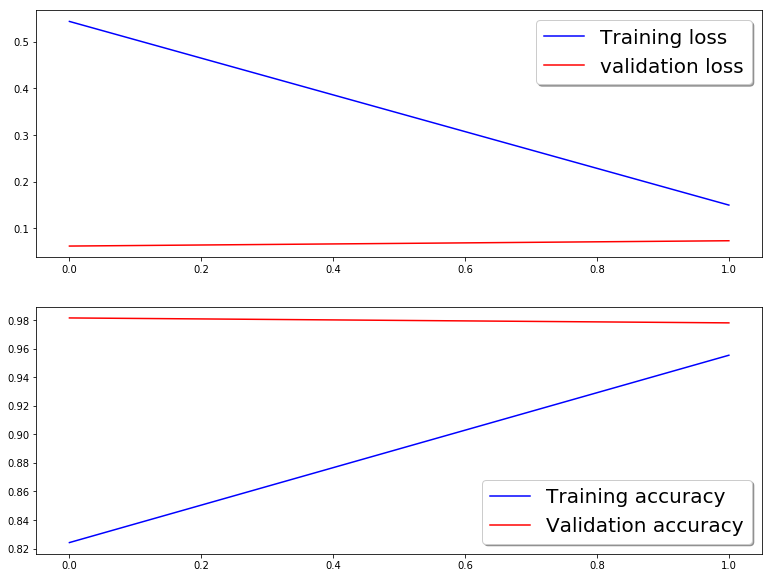

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1,figsize=(13,10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', fontsize=20, shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', fontsize=20,shadow=True)

***
A couple things to note about these plots. First, the accuracy in the validation set is always higher than that of the training set which means we didn't over fit. And second, the validation loss is always less than that of the training set which also indicates a good fit.
***

### 4.2 Confusion Matrix

***
We can also check our errors in a different way using a Confusion Matrix. What this tells us is how often a predicted label was actually a different label. For a good fit we expect the predicated and actual label to be the same.
***

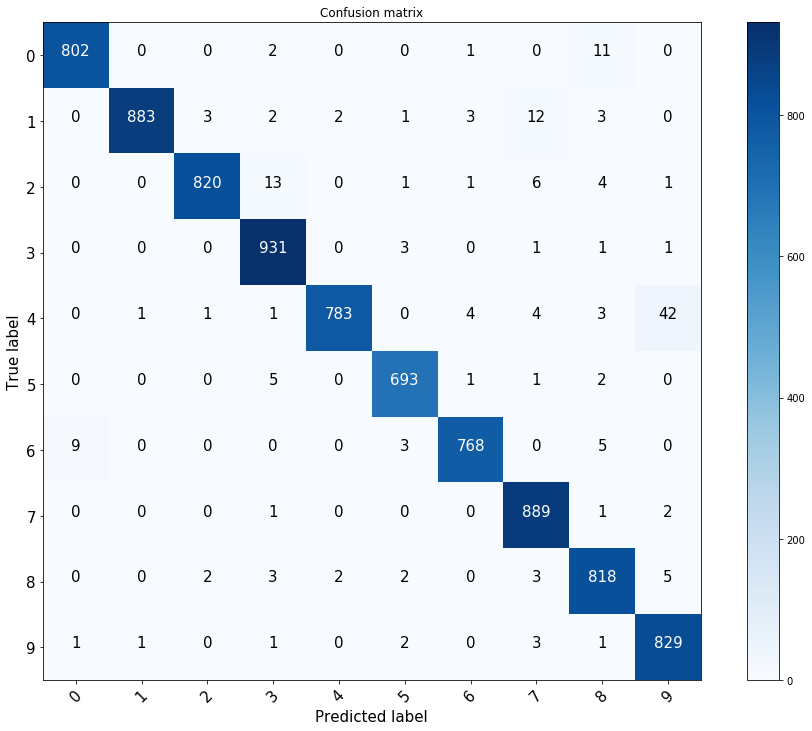

In [20]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(13,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_valid,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

***
Our model worked pretty well except with some errors getting 2's and 7's mixed up as well as 4's and 9's. However, humans also make the same errors when trying to read other's handwriting so we can't expect a machine to get it right 100% of the time either.
***

### 4.3 Exploring errors

***
The code below shows the top 6 errors the computer made in classifying numbers, getting them confused with others.
***

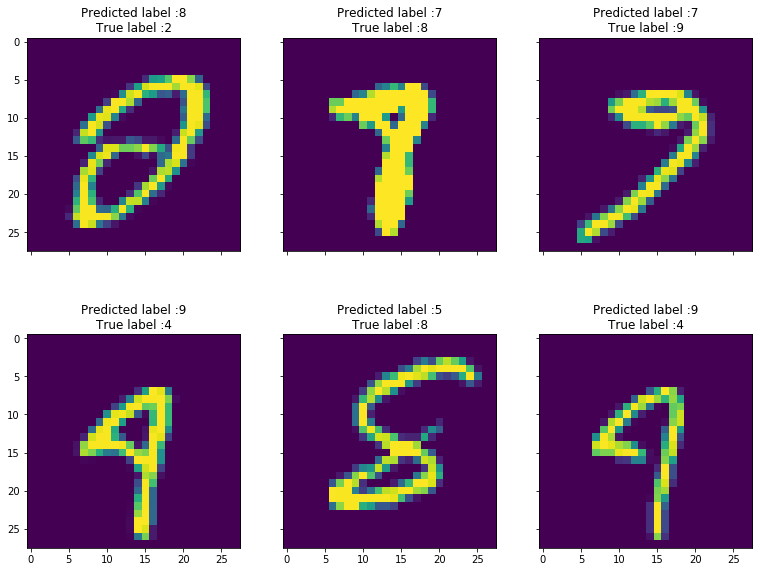

In [21]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(13,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 5. Output

***
Finally all that is left is to output the csv file for scoring.
***

In [22]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("arcsinh_mnist.csv",index=False)

***
And we are done.
***